In [1]:
import numpy as np
from sklearn import metrics
from scipy.optimize import curve_fit
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
import pandas as pd
from astropy.table import Table
import hdbscan
import seaborn as sns
from astropy.stats import sigma_clip

In [2]:
# Read the file with pandas. 
df = pd.read_csv('../catalogs_bins/DR3_errorsall_flagallf_20r21.csv')
df.describe()

,Unnamed: 0,RA,DEC,FWHM,ISOarea,KRON_RADIUS,nDet_magPStotal,PhotoFlagDet,U_PStotal,F378_PStotal,...,e_F395_PStotal,e_F410_PStotal,e_F430_PStotal,e_G_PStotal,e_F515_PStotal,e_R_PStotal,e_F660_PStotal,e_I_PStotal,e_F861_PStotal,e_Z_PStotal
count,3156.000000,3156.000000,3156.000000,3156.000000,3156.000000,3156.000000,3156.0,3156.000000,3156.000000,3156.000000,...,3156.000000,3156.000000,3156.000000,3156.000000,3156.000000,3156.000000,3156.000000,3156.000000,3156.000000,3156.000000
mean,319.611217,171.147722,-16.921049,4.276688,37.351394,4.513235,12.0,0.712928,20.760590,20.482433,...,0.159299,0.145416,0.137124,0.053717,0.104134,0.048497,0.054280,0.057965,0.122248,0.103862
std,275.435166,105.893540,14.524337,10.081260,242.136050,1.175773,0.0,1.263647,0.525001,0.477383,...,0.031239,0.031816,0.031658,0.022102,0.028532,0.013617,0.016248,0.016830,0.037118,0.034766
min,0.000000,0.023074,-56.381346,1.437413,7.000000,0.000000,12.0,0.000000,16.009724,15.625423,...,0.008842,0.005974,0.005598,0.002407,0.003861,0.023499,0.001865,0.001444,0.002544,0.001813
25%,92.000000,64.084570,-29.448641,2.209614,16.000000,3.773187,12.0,0.000000,20.446513,20.251387,...,0.141361,0.125808,0.116763,0.041544,0.085216,0.039456,0.044337,0.046771,0.096677,0.079254
50%,228.500000,161.840261,-17.417457,2.538285,19.000000,4.384516,12.0,0.000000,20.728028,20.506135,...,0.165924,0.147391,0.138059,0.049414,0.102115,0.046935,0.053262,0.056229,0.121355,0.099512
75%,516.000000,209.163061,-0.707319,3.378093,24.000000,5.129577,12.0,2.000000,21.139792,20.780315,...,0.183887,0.168941,0.159964,0.058103,0.121042,0.054271,0.062458,0.067213,0.147743,0.125638
max,1027.000000,359.853042,6.134537,254.689160,10249.000000,9.051135,12.0,19.000000,21.996246,21.474216,...,0.199987,0.199995,0.199929,0.199870,0.199936,0.165292,0.190112,0.197133,0.199846,0.199904


In [4]:
# define the true objective function
def objective(x, a, b):
    return a * x + b

# definition for the colors
def colour(table, f1, f2, f3, f4):
    xcolour = table[f1] - table[f2]
    ycolour = table[f3] - table[f4]
    return xcolour, ycolour

In [5]:
cx, cy = colour(df, "R_PStotal", "I_PStotal", "R_PStotal", "F660_PStotal")
# curve_fit
popt, _ = curve_fit(objective, cx, cy)
# summarize the parameter values
a, b = popt
print('y = %.5f * x + %.5f' % (a, b))

y = 0.81831 * x + -0.07806


In [6]:
from astropy.modeling import models, fitting

# initialize a linear fitter
fit = fitting.LinearLSQFitter()

# initialize a linear model
line_init = models.Linear1D()

# fit the data with the fitter
fitted_line = fit(line_init, cx, cy)
fitted_line

<Linear1D(slope=0.81831348, intercept=-0.07806147)>

In [26]:
# initialize the outlier removal fitter
or_fit = fitting.FittingWithOutlierRemoval(fit, sigma_clip, niter=4, sigma=4.0)


# fit the data with the fitter
fitted_line_, mask = or_fit(line_init, cx, cy)
filtered_data = np.ma.masked_array(cy, mask=mask)
fitted_line_

<Linear1D(slope=0.43481749, intercept=-0.06146406)>

In [8]:
# Create DataFrame with the new colums
colum1 = pd.DataFrame(cx, columns=['r - i'])
colum2 = pd.DataFrame(cy, columns=['r - Halpha'])
data = pd.concat([df["RA"], df["DEC"], df["FWHM"], df["R_PStotal"], colum1, colum2],axis=1)
data

,RA,DEC,FWHM,R_PStotal,r - i,r - Halpha
0,157.732419,-35.260627,2.461379,20.368105,0.006205,-0.027452
1,158.245541,-35.082083,2.186922,20.009275,-0.404795,-0.292616
2,158.849991,-34.950836,1.978504,20.057241,0.123531,0.024406
3,158.703880,-34.856533,2.297130,20.069565,0.112553,-0.041502
4,157.677856,-34.834008,2.253290,20.050520,0.156467,-0.008280
...,...,...,...,...,...,...
3151,215.072616,-24.958913,1.846155,20.212627,0.403447,0.636591
3152,214.785394,-25.033480,2.181766,20.209223,0.247645,-0.022972
3153,216.074734,-24.881852,6.217510,20.369265,0.002213,-0.209774
3154,215.075661,-24.887165,6.149331,20.206219,0.125847,0.021530


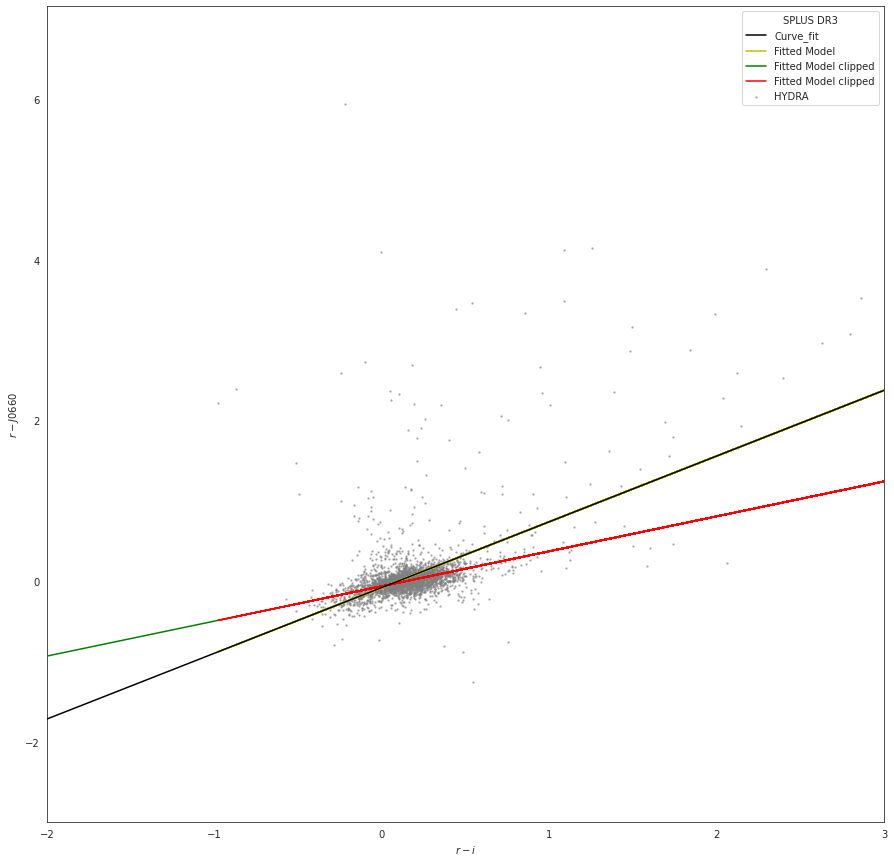

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

color_palette = sns.color_palette('Paired', 12)
with sns.axes_style('white'):
    fig, ax1 = plt.subplots(figsize=(15, 15))

    fit_line = np.linspace(-3.0, 3.0)
    scatter = ax1.scatter(
       data['r - i'], data['r - Halpha'],
        color="gray",
       s=2, 
       cmap="seismic", alpha = 0.5, zorder=4.0, label = "HYDRA")
    ax1.set(
    xlim=[-2.0, 3.0],
    #ylim=[-1.5, 3.0],
    xlabel=r"$r - i$",
    ylabel=r"$r - J0660$",)

    #ax1.plot(fit_line, 0.42744 * fit_line - 0.04264, ls=':', color="k", zorder = 9, label='HDBSCAN Curve_fit')
    ax1.plot(fit_line, 0.81831 * fit_line - 0.07806, color="k", zorder = 8, label='Curve_fit')
    #plt.plot(cx_0, line_orig(cx_0), 'b-', label='Simulation Model')
    plt.plot(data['r - i'], fitted_line(data['r - i']), 'y-', zorder = 6, label='Fitted Model')
    #plt.plot(data['r - i'], filtered_data, "ko", label="Fitted Data")
    plt.plot(fit_line, fitted_line_(fit_line), 'g-', zorder = 7, label='Fitted Model clipped')
    plt.plot(data['r - i'], fitted_line_(data['r - i']), 'r-', zorder = 7, label='Fitted Model clipped')
    #plt.plot(data['r - i'], filtered_data, 'r+', zorder=8, label="filtered data")
    #plt.plot(cx_1, fitted_model(cx_1), 'g-',
         #label="model fitted w/ original data")
    #plt.plot(cx_1, or_fitted_model(cx_1), 'r-')#, label="model fitted w/ filtered data")
    ax1.legend(ncol=1).set_title("SPLUS DR3")
    #ax1.set_aspect("equal")

# Selecting the alpha emitters

In [11]:
from sklearn.metrics import mean_squared_error

In [12]:
cy_predic = fitted_line_(data['r - i'])
sigma_fit = mean_squared_error(cy, cy_predic, squared=False)
print("The root mean squared value of the residuals around the fit:", sigma_fit)

The root mean squared value of the residuals around the fit: 0.39392616690558524


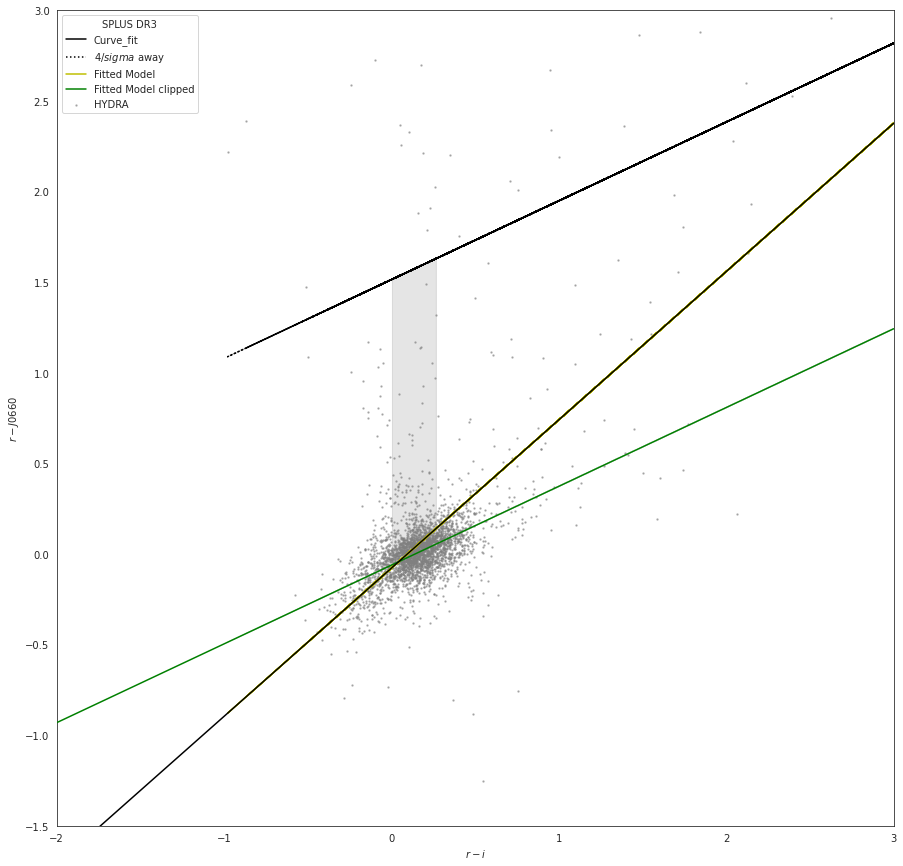

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

color_palette = sns.color_palette('Paired', 12)
with sns.axes_style('white'):
    fig, ax1 = plt.subplots(figsize=(15, 15))

    fit_line = np.linspace(-3.0, 3.0)
    scatter = ax1.scatter(
       data['r - i'], data['r - Halpha'],
       s=2, 
        color="gray",
       cmap="seismic", alpha = 0.5, zorder=4.0, label = "HYDRA")
    ax1.set(
    xlim=[-2.0, 3.0],
    ylim=[-1.5, 3.0],
    xlabel=r"$r - i$",
    ylabel=r"$r - J0660$",)
    
    #ax1.plot(fit_line, 0.42744 * fit_line - 0.04264, ls=':', color="k", zorder = 9, label='HDBSCAN Curve_fit')
    ax1.plot(fit_line, 0.81831 * fit_line - 0.07806, color="k", zorder = 8, label='Curve_fit')
    ax1.plot(data['r - i'], (fitted_line_(data['r - i'])) + 4*sigma_fit, ls=':', color="k", zorder = 8, label='4$/sigma$ away')
    plt.fill_between(data['r - i'], fitted_line_(data['r - i']), fitted_line_(data['r - i']) + 4*sigma_fit, color='k', alpha=0.1)
    #plt.plot(cx_0, line_orig(cx_0), 'b-', label='Simulation Model')
    plt.plot(data['r - i'], fitted_line(data['r - i']), 'y-', zorder = 6, label='Fitted Model')
    #plt.plot(data['r - i'], filtered_data, "ko", label="Fitted Data")
    plt.plot(fit_line, fitted_line_(fit_line), 'g-', zorder = 7, label='Fitted Model clipped')
    #plt.plot(data['r - i'], filtered_data, 'r+', zorder=8, label="filtered data")
    #plt.plot(cx_1, fitted_model(cx_1), 'g-',
         #label="model fitted w/ original data")
    #plt.plot(cx_1, or_fitted_model(cx_1), 'r-')#, label="model fitted w/ filtered data")
    ax1.legend(ncol=1).set_title("SPLUS DR3")
    #ax1.set_aspect("equal")